Disclaimer: the actual output corresponds to running a smaller version of the validation set, for a faster (and slightly worse) computation. 

In [1]:
# Aquest notebook té 25GB

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# !python -m pip install dask[dataframe] --upgrade  # or python -m pip install

In [2]:
!pip uninstall lightgbm # reinstall lightgbm to obtain the latest version in colab
!pip install lightgbm

Uninstalling lightgbm-2.2.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/lightgbm-2.2.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/lightgbm/*
Proceed (y/n)? y
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0MB 13.1MB/s 


# Train

# Load data

In [3]:
import pandas as pd
# import dask.array as da
# import dask.dataframe as dd
import os
import numpy as np

path = './gdrive/MyDrive/validation/'
df =  pd.read_csv(path + 'part-00000', sep='', encoding='utf-8', header=None) 
all_features = ['bert', 'hashtags', 'tweet_id', 'media', 'links', 'domains', 'type',
       'language', 'timestamp', 'EWUF_user_id', 'EWUF_follower_count',
       'EWUF_following_count', 'EWUF_verified', 'EWUF_account_creation',
       'EUF_user_id', 'EUF_follower_count', 'EUF_following_count',
       'EUF_verified', 'EUF_account_creation', 'engagee_follows_engager',
       'replay_timestamp', 'retweet_timestamp', 'quote_timestamp',
       'like_timestamp']
       
df.columns = all_features

### Split with repeating tweets 

In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.5, random_state = 17)

In [5]:
df_train = df_train.sample(frac=0.4, replace=True, random_state=1) # make smaller training set

### Liberate memory

In [6]:
del df_test; del df

# Transform

### Transformation functions

In [7]:
from datetime import datetime
timestamp_columns = ['timestamp','EUF_account_creation', 'EWUF_account_creation','replay_timestamp','retweet_timestamp','quote_timestamp','like_timestamp']
hoursCombinations = ['EUF_time_from_creation', 'EWUF_time_from_creation', 'diff_from_creation', 'weekday', 'hoursweekday']
popular_hashtags_encoded = ['06B910C9B63253EC90A2CFEFDBCA16CE', '39C7D662C61AA442BA20D2A006EAA12E', '7E9AEB766F61E95966456D010AD862AF', '30B81B3A82D3B7BB28B0665B9BDB64B4',
                              'C1B1B9901E33AA2663BE92BE667A022A', '5C7186255EA0910671FE63609A7740C3', 'EEDFB04300BC76ECE64AE7AB8DFF999C', 'D145847A7C57F6DE2E7C16CA981F29CA',
                              '50D49D761DBC587AD19073D8A41BE4D0', '9004114120258A56A5F42E1B321E5D4D', '7A58C9993F3EDDEEE0193CF84AACB435',
                              'C97F51206BB66832B1B76DE40C7936E2', '01A8672B101954842C0D6809ADE4C250', '620B9E3FE9B8231E8767F3731E1E74E1', '1A69D94DA6E8A5D1F79192D3FB80C775', 
                              '7683BBB548DE14CCB45ACA60F0AD9B83', '86101A70061DA4A3A216AE11F48BD5E1','C442A089DA33B1C7411F3CC6274F60E2', '580CF8A679C838C2C063A631744A7B22', '05BBC3A142403B01286F8A8ABDB2EEFF', '91C8A9A97AF0D1B666ABC447B808B812',
                           '15ED32AEEAD0896AAE12BA7850052B94', '86F5C36DD25C658130A4F125005CE8EB', '95247C93BA4711381143E86AB039407E', '19875E4EA694E7A74B4025ECCF4E19CF',
                           '9B597ACF49E09186820C359759D325FF', 'D9F46EFE32A7D46EACAD96E4D552054B', 'AC6785EF8C88D1509EF755EAAEA4C875', 'BBD612D7A4C2EB59B3334456AB2D70A3',
                           '08C02CD16B3412A168D03171FA80C58E', 'C7DB5645FD9D5D8B81407F819CE78A06', '881264CF821C09C4F851A080C82CA83D']

def transform_basic_features(df, timestamp_columns = timestamp_columns):
  df[timestamp_columns] = df[timestamp_columns].apply(lambda x: pd.to_datetime(x,unit='s'))

  df['EWUF_follow_ratio'] = (df['EWUF_following_count']/ df['EWUF_follower_count'].apply(lambda x : x+1e-6) )
  df['cross_following_ratio'] = (df['EWUF_following_count']/ df['EUF_following_count'].apply(lambda x : x+1e-6) )

  df['EUF_follow_ratio'] = (df['EUF_following_count']/ df['EUF_follower_count'].apply(lambda x : x+1e-6) )
  df['cross_follower_ratio'] = (df['EWUF_follower_count']/ df['EUF_follower_count'].apply(lambda x : x+1e-6) )

  df['EWUF_follow_ratio_bins'] = pd.qcut(df['EWUF_follow_ratio'], q=[0, 0.2, 0.4, 0.6, 0.80, 1], labels=False, precision=1)
  df['EUF_follow_ratio_bins'] = pd.qcut(df['EUF_follow_ratio'], q=[0, 0.2, 0.4, 0.6, 0.80, 1], labels=False, precision=1)

  df['EUF_verified'] = df['EUF_verified'].astype(int)
  df['EWUF_verified'] = df['EUF_verified'].astype(int)
  df['EUF_time_from_creation'] = df.EUF_account_creation.apply(lambda x: (datetime.now() - x).total_seconds()/60)
  df['EWUF_time_from_creation'] =  df.EWUF_account_creation.apply(lambda x: (datetime.now() - x).total_seconds()/60)
  df['diff_from_creation'] = (df.EUF_time_from_creation - df.EWUF_time_from_creation)
  df['engagee_follows_engager'] = df['engagee_follows_engager'].astype(int)
  df['ratioxratio'] = df['EWUF_follow_ratio']*df['EUF_follow_ratio']
  df['relevance'] = df['EUF_verified'] & df['EWUF_verified']

  df['replay_bool'] = df['replay_timestamp'].notna().astype(int)
  df['retweet_bool'] = df['retweet_timestamp'].notna().astype(int)
  df['quote_bool'] = df['quote_timestamp'].notna().astype(int)
  df['like_bool'] = df['like_timestamp'].notna().astype(int)

  df['hours'] = df.timestamp.dt.hour
  df['weekday'] = df.timestamp.dt.weekday
  df['hoursweekday'] = df['hours']/24 + df['weekday']/7
  df['numHashtags'] = df.hashtags.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
  df['numLinks'] = df.links.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
  df['numDomains'] = df.domains.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
  df['numMedia'] = df.media.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
  df['numVideo'] = df.media.apply(lambda x: x.count('Video') if pd.isna(x) == False else 0).sum()
  df['numPhoto'] = df.media.apply(lambda x: x.count('Photo') if pd.isna(x) == False else 0).sum()
  df['numGIF'] = df.media.apply(lambda x: x.count('GIF') if pd.isna(x) == False else 0).sum()
  return df

def transform_OHE(df, n = 40):
  # dummies of media
  df['Video'] = df.media.str.contains('Video', na=False).map({
      True: 1,
      False: 0
  })
  df['Photo'] = df.media.str.contains('Photo', na=False).map({
      True: 1,
      False: 0
  })
  df['GIF'] = df.media.str.contains('GIF', na=False).map({True: 1, False: 0})

  # dummies of type
  dummies = pd.get_dummies(df.type)
  df = pd.concat([df, dummies], axis=1)

  df['hours'] = df.timestamp.dt.hour
  df['weekday'] = df.timestamp.dt.weekday
  df['hoursweekday'] = df['hours']/24 + df['weekday']/7

  topHashtags = df['hashtags'].value_counts()[:n].index.tolist()
  pattern = '|'.join(list(topHashtags))
  df['topHashtags'] = df.hashtags.str.contains(pattern).replace({pd.NA : False}).astype(int)

  topDomains = df['domains'].value_counts()[:n].index.tolist()
  pattern = '|'.join(list(topDomains))
  df['topDomains'] = df.domains.str.contains(pattern).replace({pd.NA : False}).astype(int)

  topLinks = df['links'].value_counts()[:n].index.tolist()
  pattern = '|'.join(list(topLinks))
  df['topLinks'] = df.links.str.contains(pattern).replace({pd.NA : False}).astype(int)
  return df

def transform_popular_hashtags(df, popular_hashtags_encoded = popular_hashtags_encoded):
  pattern = '|'.join(list(popular_hashtags_encoded))
  df['topHashtagsInternet'] = df.hashtags.str.contains(pattern).replace({pd.NA : False}).astype(int)

  for kw in popular_hashtags_encoded:
      df[kw] = df.hashtags.str.contains(kw, na=False).map({True: 1, False: 0})
  return df

### Apply transform

In [8]:
%%time
df_train = transform_basic_features(df_train, timestamp_columns = timestamp_columns)
df_train = transform_OHE(df_train, n = 40)
df_train = transform_popular_hashtags(df_train, popular_hashtags_encoded = popular_hashtags_encoded)

CPU times: user 3min 3s, sys: 2.12 s, total: 3min 5s
Wall time: 3min 4s


# Split Train/Val

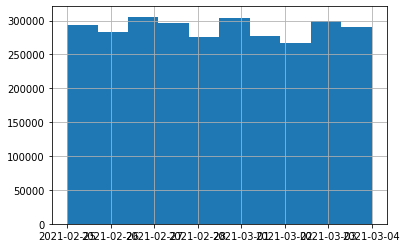

In [9]:
df_train.timestamp.hist()

In [10]:
df_val = df_train[df_train['timestamp'] > '2021-03-03 00:00:00']
df_train = df_train[df_train['timestamp'] <= '2021-03-03 00:00:00']

# Train the model

### Functions for RCE/AP

In [11]:
from sklearn.metrics import average_precision_score, log_loss

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

def compute_ap_lgb(pred, g):
    gt = np.array(g.get_label())
    pred = np.array(pred)
    ap = average_precision_score(gt, pred)
    return 'ap', ap, True

def compute_rce_lgb(pred, g):
    gt = np.array(g.get_label())
    pred = np.array(pred)
    rce = compute_rce(pred, gt)
    return 'rce',rce,True

### Actual training

In [12]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle

selected_features = ['EWUF_verified', 'EUF_verified', 'engagee_follows_engager', 'ratioxratio', 'hours', 'EWUF_follow_ratio', 'EUF_follow_ratio', 
                     'topHashtags', 'EWUF_follow_ratio_bins', 'EUF_follow_ratio_bins', 'cross_following_ratio', 'cross_follower_ratio',
                     'topHashtagsInternet', 'numHashtags', 'topDomains', 'numDomains', 'numVideo', 'numPhoto', 'numGIF', 
                     'topLinks', 'numLinks', 'Retweet', 'Quote', 'TopLevel', 'Photo', 'Video', 'GIF', 
                     'numMedia'] + hoursCombinations + popular_hashtags_encoded 

targets = ['replay_bool','retweet_bool','quote_bool','like_bool']

for target in targets:
  X_train = df_train[selected_features]; X_test = df_val[selected_features]
  y_train = df_train[target]; y_test = df_val[target] 
  train_data = lgb.Dataset(X_train, label=y_train)
  test_data = lgb.Dataset(X_test, label=y_test)
  rand_idx = np.random.permutation(len(X_train))[:150000]
  train_sampled_data = lgb.Dataset(X_train.iloc[rand_idx], y_train.iloc[rand_idx])

  param2 = {'max_depth':10, 
            'num_leaves':10,         
            'lambda_l1':10,
            'lambda_l2':10,
            'learning_rate': 0.5,
            'feature_fraction': 0.8, 
            'bagging_freq':10,        # Always perform bagging
            'bagging_fraction':0.8, # % of rows selected in each tree
            'objective':'cross_entropy',
      #          'eval_metric':'aucpr',
          'metric': 'None'   # For the null metric use 'None' instead of None:
                                  #  None  -> ob
          }
      
  # mirar com usar nomes la primera metrica en early stopping

  callbacks=[
    # First metric only to use only RCE for early stopping
    # since it is the one with higher impact
    lgb.early_stopping(50, first_metric_only=True)
  ]

  model_wd = lgb.train(param2,
                      train_data,
                      callbacks=callbacks,
                      valid_sets=[train_sampled_data, test_data],
                      num_boost_round=5000,
                      feval=[compute_rce_lgb, compute_ap_lgb],
                      verbose_eval=50) # quan estigui amb moltes dades treure el prauc

  filename = 'Non_Text_' + target + '_Model.sav'
  pickle.dump(model_wd, open(path + '/final/' + filename, 'wb'))

[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.395463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2334
[LightGBM] [Info] Number of data points in the train set: 2482135, number of used features: 49
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.021206 -> initscore = -3.832021
[LightGBM] [Info] Start training from score -3.832021
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rce: 9.73185	valid_0's ap: 0.0700282	valid_1's rce: 10.3413	valid_1's ap: 0.0684475
[100]	valid_0's rce: 10.1587	valid_0's ap: 0.0729126	valid_1's rce: 10.306	valid_1's ap: 0.0682241
Early stopping, best iteration is:
[79]	valid_0's rce: 10.003	valid_0's ap: 0.0717086	valid_1's rce: 10.3751	valid_1's ap: 0.0684651
Evaluated only: r

### Gain feature importance

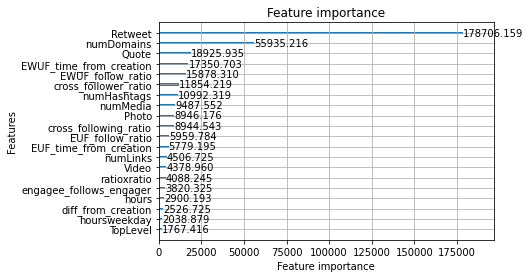

In [13]:
lgb.plot_importance(model_wd, importance_type='gain', max_num_features= 20)

# Test

# Load data

In [1]:
import pandas as pd
# import dask.array as da
# import dask.dataframe as dd
import os
import numpy as np


path = './gdrive/MyDrive/validation/'
df =  pd.read_csv(path + 'part-00000', sep='', encoding='utf-8', header=None) 
all_features = ['bert', 'hashtags', 'tweet_id', 'media', 'links', 'domains', 'type',
       'language', 'timestamp', 'EWUF_user_id', 'EWUF_follower_count',
       'EWUF_following_count', 'EWUF_verified', 'EWUF_account_creation',
       'EUF_user_id', 'EUF_follower_count', 'EUF_following_count',
       'EUF_verified', 'EUF_account_creation', 'engagee_follows_engager',
       'replay_timestamp', 'retweet_timestamp', 'quote_timestamp',
       'like_timestamp']
       
df.columns = all_features

### Split with repeating tweets

In [2]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split( df, test_size=0.5, random_state=17)

In [3]:
df_test = df_test.sample(frac=0.5, replace=True, random_state=1) # make smaller test set

### Liberate memory

In [4]:
del df_train, df

# Transformation

### Run transformation functions

In [5]:
from datetime import datetime
timestamp_columns = ['timestamp','EUF_account_creation', 'EWUF_account_creation','replay_timestamp','retweet_timestamp','quote_timestamp','like_timestamp']
hoursCombinations = ['EUF_time_from_creation', 'EWUF_time_from_creation', 'diff_from_creation', 'weekday', 'hoursweekday']
popular_hashtags_encoded = ['06B910C9B63253EC90A2CFEFDBCA16CE', '39C7D662C61AA442BA20D2A006EAA12E', '7E9AEB766F61E95966456D010AD862AF', '30B81B3A82D3B7BB28B0665B9BDB64B4',
                              'C1B1B9901E33AA2663BE92BE667A022A', '5C7186255EA0910671FE63609A7740C3', 'EEDFB04300BC76ECE64AE7AB8DFF999C', 'D145847A7C57F6DE2E7C16CA981F29CA',
                              '50D49D761DBC587AD19073D8A41BE4D0', '9004114120258A56A5F42E1B321E5D4D', '7A58C9993F3EDDEEE0193CF84AACB435',
                              'C97F51206BB66832B1B76DE40C7936E2', '01A8672B101954842C0D6809ADE4C250', '620B9E3FE9B8231E8767F3731E1E74E1', '1A69D94DA6E8A5D1F79192D3FB80C775', 
                              '7683BBB548DE14CCB45ACA60F0AD9B83', '86101A70061DA4A3A216AE11F48BD5E1','C442A089DA33B1C7411F3CC6274F60E2', '580CF8A679C838C2C063A631744A7B22', '05BBC3A142403B01286F8A8ABDB2EEFF', '91C8A9A97AF0D1B666ABC447B808B812',
                           '15ED32AEEAD0896AAE12BA7850052B94', '86F5C36DD25C658130A4F125005CE8EB', '95247C93BA4711381143E86AB039407E', '19875E4EA694E7A74B4025ECCF4E19CF',
                           '9B597ACF49E09186820C359759D325FF', 'D9F46EFE32A7D46EACAD96E4D552054B', 'AC6785EF8C88D1509EF755EAAEA4C875', 'BBD612D7A4C2EB59B3334456AB2D70A3',
                           '08C02CD16B3412A168D03171FA80C58E', 'C7DB5645FD9D5D8B81407F819CE78A06', '881264CF821C09C4F851A080C82CA83D']

def transform_basic_features(df, timestamp_columns = timestamp_columns):
  df[timestamp_columns] = df[timestamp_columns].apply(lambda x: pd.to_datetime(x,unit='s'))

  df['EWUF_follow_ratio'] = (df['EWUF_following_count']/ df['EWUF_follower_count'].apply(lambda x : x+1e-6) )
  df['cross_following_ratio'] = (df['EWUF_following_count']/ df['EUF_following_count'].apply(lambda x : x+1e-6) )

  df['EUF_follow_ratio'] = (df['EUF_following_count']/ df['EUF_follower_count'].apply(lambda x : x+1e-6) )
  df['cross_follower_ratio'] = (df['EWUF_follower_count']/ df['EUF_follower_count'].apply(lambda x : x+1e-6) )

  df['EWUF_follow_ratio_bins'] = pd.qcut(df['EWUF_follow_ratio'], q=[0, 0.2, 0.4, 0.6, 0.80, 1], labels=False, precision=1)
  df['EUF_follow_ratio_bins'] = pd.qcut(df['EUF_follow_ratio'], q=[0, 0.2, 0.4, 0.6, 0.80, 1], labels=False, precision=1)

  df['EUF_verified'] = df['EUF_verified'].astype(int)
  df['EWUF_verified'] = df['EUF_verified'].astype(int)
  df['EUF_time_from_creation'] = df.EUF_account_creation.apply(lambda x: (datetime.now() - x).total_seconds()/60)
  df['EWUF_time_from_creation'] =  df.EWUF_account_creation.apply(lambda x: (datetime.now() - x).total_seconds()/60)
  df['diff_from_creation'] = (df.EUF_time_from_creation - df.EWUF_time_from_creation)
  df['engagee_follows_engager'] = df['engagee_follows_engager'].astype(int)
  df['ratioxratio'] = df['EWUF_follow_ratio']*df['EUF_follow_ratio']
  df['relevance'] = df['EUF_verified'] & df['EWUF_verified']

  df['replay_bool'] = df['replay_timestamp'].notna().astype(int)
  df['retweet_bool'] = df['retweet_timestamp'].notna().astype(int)
  df['quote_bool'] = df['quote_timestamp'].notna().astype(int)
  df['like_bool'] = df['like_timestamp'].notna().astype(int)

  df['hours'] = df.timestamp.dt.hour
  df['weekday'] = df.timestamp.dt.weekday
  df['hoursweekday'] = df['hours']/24 + df['weekday']/7
  df['numHashtags'] = df.hashtags.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
  df['numLinks'] = df.links.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
  df['numDomains'] = df.domains.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
  df['numMedia'] = df.media.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
  df['numVideo'] = df.media.apply(lambda x: x.count('Video') if pd.isna(x) == False else 0).sum()
  df['numPhoto'] = df.media.apply(lambda x: x.count('Photo') if pd.isna(x) == False else 0).sum()
  df['numGIF'] = df.media.apply(lambda x: x.count('GIF') if pd.isna(x) == False else 0).sum()
  return df

def transform_OHE(df, n = 40):
  # dummies of media
  df['Video'] = df.media.str.contains('Video', na=False).map({
      True: 1,
      False: 0
  })
  df['Photo'] = df.media.str.contains('Photo', na=False).map({
      True: 1,
      False: 0
  })
  df['GIF'] = df.media.str.contains('GIF', na=False).map({True: 1, False: 0})

  # dummies of type
  dummies = pd.get_dummies(df.type)
  df = pd.concat([df, dummies], axis=1)

  df['hours'] = df.timestamp.dt.hour
  df['weekday'] = df.timestamp.dt.weekday
  df['hoursweekday'] = df['hours']/24 + df['weekday']/7

  topHashtags = df['hashtags'].value_counts()[:n].index.tolist()
  pattern = '|'.join(list(topHashtags))
  df['topHashtags'] = df.hashtags.str.contains(pattern).replace({pd.NA : False}).astype(int)

  topDomains = df['domains'].value_counts()[:n].index.tolist()
  pattern = '|'.join(list(topDomains))
  df['topDomains'] = df.domains.str.contains(pattern).replace({pd.NA : False}).astype(int)

  topLinks = df['links'].value_counts()[:n].index.tolist()
  pattern = '|'.join(list(topLinks))
  df['topLinks'] = df.links.str.contains(pattern).replace({pd.NA : False}).astype(int)
  return df

def transform_popular_hashtags(df, popular_hashtags_encoded = popular_hashtags_encoded):
  pattern = '|'.join(list(popular_hashtags_encoded))
  df['topHashtagsInternet'] = df.hashtags.str.contains(pattern).replace({pd.NA : False}).astype(int)

  for kw in popular_hashtags_encoded:
      df[kw] = df.hashtags.str.contains(kw, na=False).map({True: 1, False: 0})
  return df

### Transform

In [6]:
df_test = transform_basic_features(df_test, timestamp_columns = timestamp_columns)
df_test = transform_OHE(df_test, n = 40)
df_test = transform_popular_hashtags(df_test, popular_hashtags_encoded = popular_hashtags_encoded)

hoursCombinations = ['EUF_time_from_creation', 'EWUF_time_from_creation', 'diff_from_creation', 'weekday', 'hoursweekday']
popular_hashtags_encoded = ['06B910C9B63253EC90A2CFEFDBCA16CE', '39C7D662C61AA442BA20D2A006EAA12E', '7E9AEB766F61E95966456D010AD862AF', '30B81B3A82D3B7BB28B0665B9BDB64B4',
                              'C1B1B9901E33AA2663BE92BE667A022A', '5C7186255EA0910671FE63609A7740C3', 'EEDFB04300BC76ECE64AE7AB8DFF999C', 'D145847A7C57F6DE2E7C16CA981F29CA',
                              '50D49D761DBC587AD19073D8A41BE4D0', '9004114120258A56A5F42E1B321E5D4D', '7A58C9993F3EDDEEE0193CF84AACB435',
                              'C97F51206BB66832B1B76DE40C7936E2', '01A8672B101954842C0D6809ADE4C250', '620B9E3FE9B8231E8767F3731E1E74E1', '1A69D94DA6E8A5D1F79192D3FB80C775', 
                              '7683BBB548DE14CCB45ACA60F0AD9B83', '86101A70061DA4A3A216AE11F48BD5E1','C442A089DA33B1C7411F3CC6274F60E2', '580CF8A679C838C2C063A631744A7B22', '05BBC3A142403B01286F8A8ABDB2EEFF', '91C8A9A97AF0D1B666ABC447B808B812',
                           '15ED32AEEAD0896AAE12BA7850052B94', '86F5C36DD25C658130A4F125005CE8EB', '95247C93BA4711381143E86AB039407E', '19875E4EA694E7A74B4025ECCF4E19CF',
                           '9B597ACF49E09186820C359759D325FF', 'D9F46EFE32A7D46EACAD96E4D552054B', 'AC6785EF8C88D1509EF755EAAEA4C875', 'BBD612D7A4C2EB59B3334456AB2D70A3',
                           '08C02CD16B3412A168D03171FA80C58E', 'C7DB5645FD9D5D8B81407F819CE78A06', '881264CF821C09C4F851A080C82CA83D']
selected_features = ['EWUF_verified', 'EUF_verified', 'engagee_follows_engager', 'ratioxratio', 'hours', 'EWUF_follow_ratio', 'EUF_follow_ratio', 
                     'topHashtags', 'EWUF_follow_ratio_bins', 'EUF_follow_ratio_bins', 'cross_following_ratio', 'cross_follower_ratio',
                     'topHashtagsInternet', 'numHashtags', 'topDomains', 'numDomains', 'numVideo', 'numPhoto', 'numGIF', 
                     'topLinks', 'numLinks', 'Retweet', 'Quote', 'TopLevel', 'Photo', 'Video', 'GIF', 
                     'numMedia'] + hoursCombinations + popular_hashtags_encoded 

X = df_test[selected_features]
targets = ['replay_bool','retweet_bool','quote_bool','like_bool']
gt = df_test[targets]
del df_test

# Obtaining metrics

In [7]:
from sklearn.metrics import average_precision_score, log_loss
import pickle 

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

path = './gdrive/MyDrive/validation/final/'
engagement = ['replay', 'retweet', 'quote', 'like']
for eng, target in zip(engagement, targets):
  print(eng)
  Model = pickle.load(open(path + 'Non_Text_' + target + '_Model.sav', 'rb'))
  predictions = Model.predict(X)
  rce = compute_rce(predictions, gt[target].values)
  average_precision = average_precision_score(gt[target].values, predictions)
  print(f'RCE: {rce}')
  print(f'AP: {average_precision}')

replay
RCE: 9.764998165884453
AP: 0.06534085229363844
retweet
RCE: 4.998924133212357
AP: 0.15599132687438175
quote
RCE: 2.732163327223436
AP: 0.011214393381142874
like
RCE: 9.770212440400583
AP: 0.590805672935449
